In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt
import joblib
from openpyxl import Workbook 


output_dir = './output'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


train_data = pd.read_excel('114.xls', engine='xlrd') 
pre_data = pd.read_excel('pre3.xls', engine='xlrd')  


X_train = train_data[['MD', 'CSDA', 'MH', 'WFL', 'LT']]
y_train = train_data['HFWCZ']

X_pre = pre_data[['MD', 'CSDA', 'MH', 'WFL', 'LT']]  


X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


rf_model = RandomForestRegressor()


param_grid = {
    'n_estimators': [20, 40, 60],
    'max_depth': [None, 2, 4, 6],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}


grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=5, verbose=1, n_jobs=-1)


grid_search.fit(X_train, y_train)

print("best: ", grid_search.best_params_)


best_rf_model = grid_search.best_estimator_


joblib.dump(best_rf_model, os.path.join(output_dir, 'rf_model.pkl'))


y_train_pred = best_rf_model.predict(X_train)


y_val_pred = best_rf_model.predict(X_val)


y_pre_pred = best_rf_model.predict(X_pre)


print("result：")
for i, pred in enumerate(y_pre_pred, start=1):
    if 'HFWCZ' in pre_data.columns: 
        true_value = pre_data['HFWCZ'].values[i-1]
        if abs(pred - true_value) / true_value > 0.1:  
            print(f"sam {i}: over，pre = {pred:.4f} m，ture = {true_value:.4f} m")
        else:
            print(f"sam {i}: pre = {pred:.4f} m")
    else:
        print(f"sam {i}: pre = {pred:.4f} m")


mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)


print(f"test MSE: {mse_train:.4f}")
print(f"test RMSE: {rmse_train:.4f}")
print(f"test MAE: {mae_train:.4f}")
print(f"test R2: {r2_train:.4f}")


y_pre_true = pre_data['HFWCZ'].values if 'HFWCZ' in pre_data.columns else None  

if y_pre_true is not None:
    mse_pre = mean_squared_error(y_pre_true, y_pre_pred)
    rmse_pre = np.sqrt(mse_pre)
    mae_pre = mean_absolute_error(y_pre_true, y_pre_pred)
    r2_pre = r2_score(y_pre_true, y_pre_pred)


    print(f"pre MSE: {mse_pre:.4f}")
    print(f"pre RMSE: {rmse_pre:.4f}")
    print(f"pre MAE: {mae_pre:.4f}")
    print(f"pre R2: {r2_pre:.4f}")


output_excel = os.path.join(output_dir, 'rf-model_predictions_and_evaluation.xlsx')


wb = Workbook()
ws = wb.active
ws.title = "Predictions and Evaluation"


ws.append(["No", "true", "pre"])


for i, pred in enumerate(y_pre_pred, start=1):
    true_value = y_pre_true[i - 1] if y_pre_true is not None else None
    ws.append([i, true_value, pred])


eval_sheet = wb.create_sheet(title="Model Evaluation")


eval_sheet.append(["No", "train", "pre"])
eval_sheet.append(["MSE", mse_train, mse_pre if y_pre_true is not None else "N/A"])
eval_sheet.append(["RMSE", rmse_train, rmse_pre if y_pre_true is not None else "N/A"])
eval_sheet.append(["MAE", mae_train, mae_pre if y_pre_true is not None else "N/A"])
eval_sheet.append(["R²", r2_train, r2_pre if y_pre_true is not None else "N/A"])


wb.save(output_excel)

print(f"rusult {output_excel}")


y_train = np.squeeze(np.array(y_train))  
y_train_pred = np.squeeze(np.array(y_train_pred))  
y_val = np.squeeze(np.array(y_val)) 
y_val_pred = np.squeeze(np.array(y_val_pred))  

D:\Anaconda\Anaconda3-2020.07\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   19.4s


最佳参数:  {'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 40}
预测集的预测结果：
样本 1: 预测的水导裂缝带高度 = 46.9497 米
样本 2: 跳过此预测值，预测 = 49.6402 米，真实值 = 40.0000 米
样本 3: 跳过此预测值，预测 = 46.8248 米，真实值 = 56.8000 米
样本 4: 跳过此预测值，预测 = 29.2475 米，真实值 = 25.3000 米
训练集 MSE: 71.5301
训练集 RMSE: 8.4575
训练集 MAE: 6.7385
训练集 R2: 0.9398
预测集 MSE: 53.3276
预测集 RMSE: 7.3026
预测集 MAE: 6.4657
预测集 R2: 0.5806
预测结果和模型评估已保存到 ./output\rf-model_predictions_and_evaluation.xlsx


[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   25.2s finished


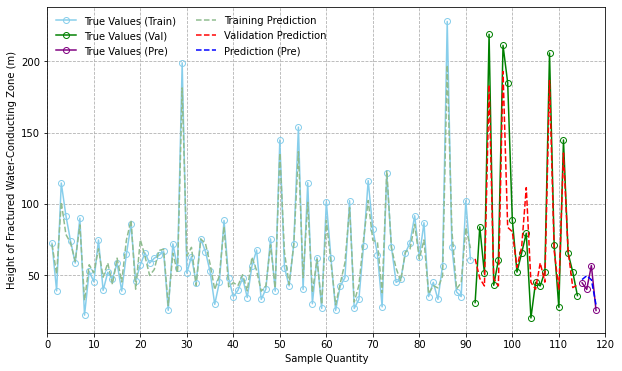

In [2]:

plt.figure(figsize=(10, 6))


pre_index = np.arange(len(y_train) + len(y_val) + 1, len(y_train) + len(y_val) + len(y_pre_pred) + 1)


train_index = np.arange(1, len(y_train) + 1)
plt.plot(train_index, y_train, 'o-', label="True Values (Train)", color='skyblue', markerfacecolor='none')


val_index = np.arange(len(y_train) + 1, len(y_train) + len(y_val) + 1)
plt.plot(val_index, y_val, 'o-', label="True Values (Val)", color='green', markerfacecolor='none')


if y_pre_true is not None:
    plt.plot(pre_index, y_pre_true, 'o-', label="True Values (Pre)", color='purple', markerfacecolor='none')

plt.plot(train_index, y_train_pred, '--', label="Training Prediction", color="#8FBC8F")
plt.plot(val_index, y_val_pred, '--', label="Validation Prediction", color='red')


plt.plot(pre_index, y_pre_pred, '--', label="Prediction (Pre)", color='blue')


plt.xlim([0, len(y_train) + len(y_val) + len(y_pre_pred)])
plt.xticks(np.arange(0, len(y_train) + len(y_val) + len(y_pre_pred) + 10, 10))
plt.xlabel('Sample Quantity')
plt.ylabel('Height of Fractured Water-Conducting Zone (m)')
plt.legend(loc='upper left', bbox_to_anchor=(0, 1), frameon=False, ncol=2)
plt.grid(True, linestyle='--')

plt.savefig(os.path.join(output_dir, 'pre-rf-with-pre-data.png'), dpi=300)
plt.savefig(os.path.join(output_dir, 'pre-rf-with-pre-data.pdf'))
plt.show()